## Evaluating distributional forecast accuracy
***
The preceding measures all measure point forecast accuracy. When evaluating distributional forecasts, we need to use some other measures.

## Quantile scores

Consider the Google stock price example from the previous section. Figure 23 shows an 80% prediction interval for the forecasts from the Auto ARIMA method.

In [55]:
#Import the libraries that we are going to use for the analysis:
import pandas as pd
import numpy as np
import random
from itertools import product
from ipywidgets import interact

from statsforecast import StatsForecast
from statsforecast.models import __all__

import matplotlib.pyplot as plt

In [56]:
# Create a dataframe from a csv file:
google_stock = pd.read_csv("Assets/GOOGL.csv")

# Filter the year of interest:
google_mask = google_stock["Date"] <= "2015-12-31"
google_2015 = google_stock[google_mask]

# Filter the year of interest:
google_mask = google_stock["Date"] > "2015-12-31"
google_2016 = google_stock[google_mask]

# Define a new dataframe with daily close prices and dates:
google_train = google_2015[["Date", "Close"]]
google_test = google_2016[["Date", "Close"]]

# Rename columns:
google_train.columns = ["ds", "y"]
google_test.columns = ["ds", "y"]

# Create a new column in the dataframe, unique_id:
google_train["unique_id"] = "Close price"
google_test["unique_id"] = "Close price"

# Convert string Date time into Python Date time object:
google_train['ds'] = pd.to_datetime(google_train['ds'])
google_test['ds'] = pd.to_datetime(google_test['ds'])

In [57]:
# import the model that we are going to use for the analysis:
from statsforecast.models import AutoARIMA

# Since we are dealing with daily data, it would be benefitial to use 5 as seasonality.
models = [AutoARIMA(season_length=5, approximation=True)]

In [58]:
# Define the model, fit and predict:
fcst = StatsForecast(df=google_train, 
                     models=models,
                     freq="D",
                     n_jobs=-1)

In [59]:
# We can define the level of the forecast intervals we want to produce. StatsForecast will produce these levels:
levels = [80]

In [60]:
# The forecast function converts the forecast distributions into intervals:
forecasts = fcst.forecast(h=30, level=levels)

In [61]:
# Reset the index of the DataFrame, and use the default one instead:
forecasts = forecasts.reset_index()

In [62]:
# Merge test dataframe with forecast predicted
df_plot_1 = google_test.merge(forecasts, left_on='ds', right_on='ds')

# Concatenate train dataframe with the previous dataframe
df_plot_2 = pd.concat([google_train, df_plot_1]).set_index('ds')

df_plot_2

,y,unique_id,unique_id_x,unique_id_y,AutoARIMA,AutoARIMA-lo-80,AutoARIMA-hi-80
ds,,,,,,,
2015-01-02,26.477501,Close price,NaN,NaN,NaN,NaN,NaN
2015-01-05,25.973000,Close price,NaN,NaN,NaN,NaN,NaN
2015-01-06,25.332001,Close price,NaN,NaN,NaN,NaN,NaN
2015-01-07,25.257500,Close price,NaN,NaN,NaN,NaN,NaN
2015-01-08,25.345501,Close price,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2016-01-22,37.272999,NaN,Close price,Close price,38.82832,35.041546,42.615097
2016-01-25,36.681000,NaN,Close price,Close price,38.82832,34.789295,42.867348
2016-01-26,36.689499,NaN,Close price,Close price,38.82832,34.708645,42.947998


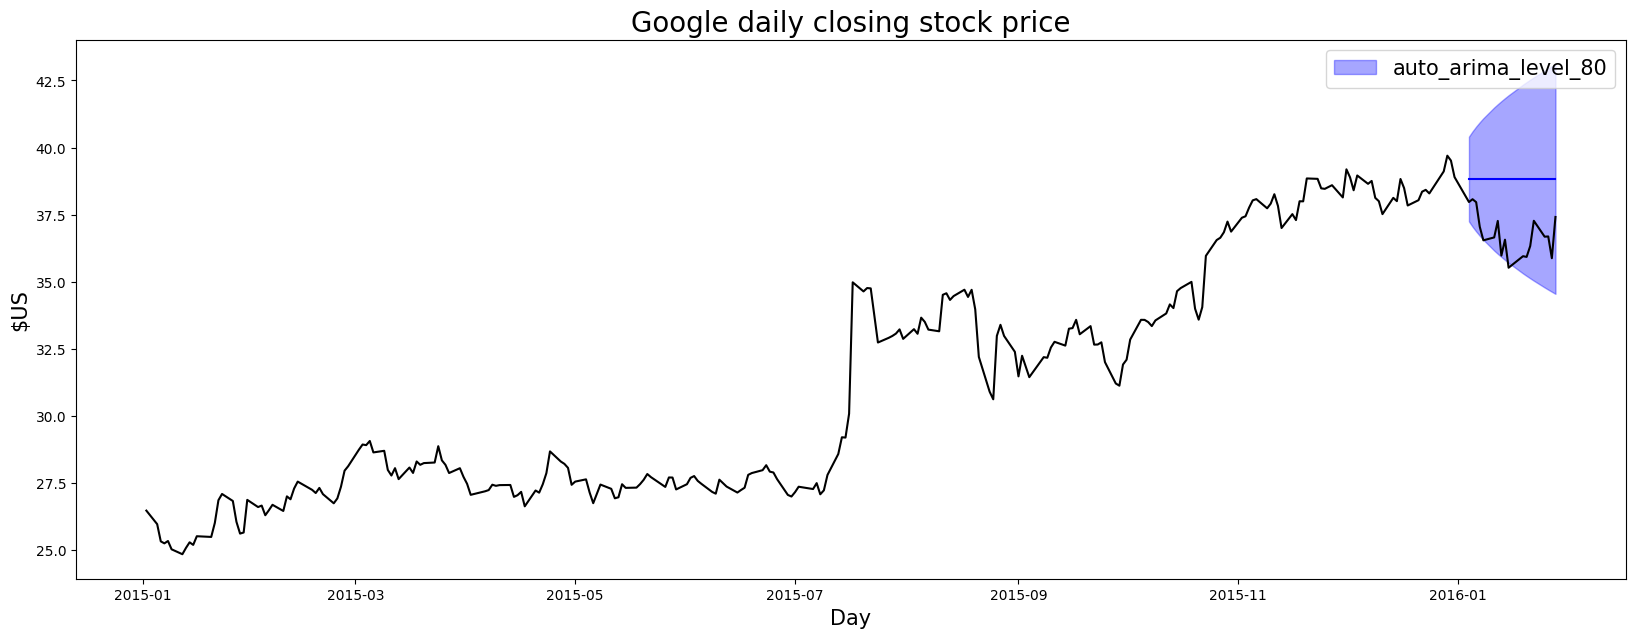

In [63]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

plt.plot(df_plot_2['y'], 'k-', df_plot_2['AutoARIMA'], 'b-')

# Specify graph features:
ax.fill_between(df_plot_2.index, 
                df_plot_2['AutoARIMA-lo-80'], 
                df_plot_2['AutoARIMA-hi-80'],
                alpha=.35,
                color='blue',
                label='auto_arima_level_80')
ax.set_title('Google daily closing stock price', fontsize=20)
ax.set_ylabel('$US', fontsize=15)
ax.set_xlabel('Day', fontsize=15)
ax.legend(prop={'size': 15})

The lower limit of this prediction interval gives the 10th percentile (or 0.1 quantile) of the forecast distribution, so we would expect the actual value to lie below the lower limit about 10% of the time, and to lie above the lower limit about 90% of the time. When we compare the actual value to this percentile, we need to allow for the fact that it is more likely to be above than below.

More generally, suppose we are interested in the quantile forecast with probability $p$ at future time $t$, and let this be denoted by ${f}_{p,t}$. That is, we expect the observation ${y}_{t}$ to be less than  with probability ${f}_{p,t}$. For example, the 10th percentile would be ${f}_{0.10,t}$. If ${y}_{t}$ denotes the observation at time $t$, then the Quantile Score is

$$
{Q}_{p,t}=
\begin{cases}
2 - (1-p) ({f}_{p,t} - {y}_{t}) & \quad \text{if ${y}_{t}<{f}_{p,t}$}\\ 
2p - ({y}_{t} - {f}_{p,t}) & \quad \text{if ${y}_{t} \ge {f}_{p,t}$}
\end{cases}
$$

This is sometimes called the “pinball loss function” because a graph of it resembles the trajectory of a ball on a pinball table. The multiplier of 2 is often omitted, but including it makes the interpretation a little easier. A low value of ${Q}_{p,t}$ indicates a better estimate of the quantile.

The quantile score can be interpreted like an absolute error. In fact, when $p = 0.5$, the quantile score ${Q}_{0.5,t}$ is the same as the absolute error. For other values of $p$, the “error” $({y}_{t} - {f}_{p,t})$ is weighted to take account of how likely it is to be positive or negative. If $p>0.5$, ${Q}_{p,t}$ gives a heavier penalty when the observation is greater than the estimated quantile than when the observation is less than the estimated quantile. The reverse is true for $p<0.5$.

In Figure 23, the one-step-ahead 10% quantile forecast (for 4 January 2016) is ${f}_{0.1,t} = 37.22$ and the observed value is 741.84. Then

\begin{gather*} 
{Q}_{0.5,t} = 2(1−0.1)(37.22−37.09) = 0.234
\end{gather*}

This is easily computed using the `quantile_score()` function:

In [64]:
'''
quantile_score() function: Return quantile score.

* prob: Percentile analized.
* f: Int. number, interval value predicted.
* y: Int. number, value observed.'''

def quantile_score(prob, f, y):

    if y >= f:
        q_score = 2 * prob * (y-f)
    else:
        q_score = 2 * (1-prob) * (f-y)  

    return q_score

In [65]:
quantile_score(0.1, df_plot_1['AutoARIMA-lo-80'][0], df_plot_1['y'][0])

0.14467084350585965

## Winkler Score

It is often of interest to evaluate a prediction interval, rather than a few quantiles, and the Winkler score proposed by Winkler (1972) is designed for this purpose. If the $100(1−α)%$ prediction interval at time $t$ is given by $[{ℓ}_{α,t},{u}_{α,t}]$, then the Winkler score is defined as the length of the interval plus a penalty if the observation is outside the interval:

$$
{W}_{α,t}=
\begin{cases}
({u}_{α,t} - {ℓ}_{α,t}) + \frac{2}{α} ({ℓ}_{α,t} - {y}_{t}) & \quad \text{if ${y}_{t} < {ℓ}_{α,t}$}\\ 
({u}_{α,t} - {ℓ}_{α,t}) & \quad \text{if ${ℓ}_{α,t} \le {y}_{t} \le {u}_{α,t}$}\\ 
({u}_{α,t} - {ℓ}_{α,t}) + \frac{2}{α} ({y}_{t} - {u}_{α,t}) & \quad \text{if ${y}_{t} > {u}_{α,t}$}\\ 
\end{cases}
$$

For observations that fall within the interval, the Winkler score is simply the length of the interval. So low scores are associated with narrow intervals. However, if the observation falls outside the interval, the penalty applies, with the penalty proportional to how far the observation is outside the interval.

Prediction intervals are usually constructed from quantiles by setting ${ℓ}_{α,t} = {f}_{α/2,t}$ and ${u}_{α,t} = {f}_{1-α/2,t}$. If we add the corresponding quantile scores and divide by $α$, we get the Winkler score:

\begin{gather*} 
{W}_{α,t} = ({Q}_{α/2,t} + {Q}_{1-α/2,t})/α
\end{gather*}

The one-step-ahead 80% interval shown in Figure 23 for 4 January 2016 is [37.22, 38.66], and the actual value was 37.09, so the Winkler score is

\begin{gather*} 
{W}_{α,t} = (38.66−37.22) + \frac{2}{0.2} (37.22−37.09) = 2.74
\end{gather*}

This is easily computed using the `winkler_score()` function:

In [66]:
'''
winkler_score() function: Return winkler score.

* a: Percentile analized.
* l: Int. number, low interval value predicted.
* u: Int. number, high interval value predicted.
* y: Int. number, value observed.'''

def winkler_score(a, l, u, y):

    if y < l:
        winkler_score = (u-l) + 2/a * (l-y)
    if l < y < u:
        winkler_score = (u-l)
    if y > u:
        winkler_score = (u-l) + 2/a * (y-u)

    return winkler_score

In [67]:
winkler_score(0.1, df_plot_1['AutoARIMA-lo-80'][0], df_plot_1['AutoARIMA-hi-80'][0], df_plot_1['y'][0])

3.1593513

## Continuous Ranked Probability Score

Often we are interested in the whole forecast distribution, rather than particular quantiles or prediction intervals. In that case, we can average the quantile scores over all values of $p$ to obtain the **Continuous Ranked Probability Score** or CRPS (Gneiting & Katzfuss, 2014).

In the Google stock price example, we can compute the average CRPS value for all days in the test set. A CRPS value is a little like a weighted absolute error computed from the entire forecast distribution, where the weighting takes account of the probabilities.

In [68]:
'''
create_levels() function: Return a dataframe with AutoARIMA [10 to 90] prediction intervals.

* train_dataframe: Dataframe with train values and time variable (ds).
* test_dataframe: Dataframe with test values and time variable (ds).
* season_length: int, number of observations per unit of time. Ex: 24 Hourly data.
* freq: str, forecast frequency ('H', 'D', 'W', 'M', 'Q', 'Y').
* horizon: int, forecast length. '''

def create_levels(train_dataframe, test_dataframe, season_length, freq, horizon):

    models = [AutoARIMA(season_length=season_length, approximation=True)]

    fcst = StatsForecast(df=train_dataframe, 
                     models=models,
                     freq=freq,
                     n_jobs=-1)

    levels = [90, 80, 70, 60, 50, 40, 30, 20, 10]
    forecasts = fcst.forecast(h=horizon, level=levels)        
    forecasts = forecasts.reset_index()   
    df_fore = test_dataframe.merge(forecasts, left_on='ds', right_on='ds')

    return df_fore

In [69]:
df_fore = create_levels(google_train, google_test, 5, 'D', 30)
df_fore

,ds,y,unique_id_x,unique_id_y,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-lo-80,AutoARIMA-lo-70,AutoARIMA-lo-60,AutoARIMA-lo-50,...,AutoARIMA-lo-10,AutoARIMA-hi-10,AutoARIMA-hi-20,AutoARIMA-hi-30,AutoARIMA-hi-40,AutoARIMA-hi-50,AutoARIMA-hi-60,AutoARIMA-hi-70,AutoARIMA-hi-80,AutoARIMA-hi-90
0,2016-01-04,37.972000,Close price,Close price,38.82832,36.800831,37.248646,37.550785,37.790916,37.996929,...,38.673428,38.983215,39.140602,39.303276,39.474712,39.659714,39.865726,40.105858,40.407997,40.855812
1,2016-01-05,38.076500,Close price,Close price,38.82832,36.549133,37.052544,37.392189,37.662132,37.893715,...,38.654198,39.002445,39.179371,39.362240,39.554955,39.762924,39.994511,40.264454,40.604099,41.107510
2,2016-01-06,37.966499,Close price,Close price,38.82832,36.322594,36.876038,37.249447,37.546219,37.800823,...,38.636890,39.019749,39.214264,39.415310,39.627178,39.855820,40.110424,40.407196,40.780602,41.334049
3,2016-01-07,37.049999,Close price,Close price,38.82832,36.114902,36.714222,37.118576,37.439949,37.715656,...,38.621025,39.035618,39.246254,39.463963,39.693394,39.940987,40.216694,40.538063,40.942421,41.541740
4,2016-01-08,36.545502,Close price,Close price,38.82832,35.922016,36.563938,36.997040,37.341255,37.636559,...,38.606289,39.050354,39.275963,39.509148,39.754890,40.020084,40.315388,40.659603,41.092705,41.734627
5,2016-01-11,36.653500,Close price,Close price,38.82832,35.408009,36.163460,36.673161,37.078251,37.425785,...,38.567020,39.089622,39.355133,39.629559,39.918762,40.230858,40.578392,40.983482,41.493183,42.248634
6,2016-01-12,37.266998,Close price,Close price,38.82832,35.253056,36.042732,36.575523,36.998966,37.362247,...,38.555183,39.101460,39.378998,39.665855,39.968163,40.294395,40.657673,41.081120,41.613911,42.403587
7,2016-01-13,35.978500,Close price,Close price,38.82832,35.104546,35.927025,36.481945,36.922981,37.301350,...,38.543839,39.112804,39.401871,39.700645,40.015507,40.355293,40.733662,41.174698,41.729618,42.552094
8,2016-01-14,36.569500,Close price,Close price,38.82832,34.961739,35.815758,36.391960,36.849911,37.242786,...,38.532928,39.123714,39.423870,39.734100,40.061039,40.413857,40.806732,41.264683,41.840885,42.694904
9,2016-01-15,35.524502,Close price,Close price,38.82832,34.824017,35.708458,36.305183,36.779442,37.186314,...,38.522408,39.134235,39.445080,39.766361,40.104946,40.470329,40.877201,41.351460,41.948185,42.832623


In [70]:
'''
crps() function: Return Continuous Ranked Probability Score.

* df: Dataframe with test values and forecast intervals values.
* model: Model analized name.
* levels_list: list, levels analized. '''

def crps(df, model, levels_list):

    import re

    obs_values = df.y
    q_scores = []
    
    lvl_lo, lvl_hi = model+'-lo-', model+'-hi-'
    lvl_low = [lvl_lo+str(i) for i in levels_list]
    lvl_high = [lvl_hi+str(i) for i in levels_list]
    lvl_list = lvl_low + lvl_high

    for level in lvl_list:
        s = -[float(s) for s in re.findall(r'-?\d+\.?\d*', level)][0]
        prob = (1- s/100) / 2
        res = obs_values-df[level]

        for e in res:

            if e > 0:
                q_score = 2 * prob * (obs_values-df[level])
                
            else:
                q_score = 2 * (1-prob) * (df[level]-obs_values)  
            
            q_scores.append(q_score)

    crps = np.average(q_scores)

    return crps

In [71]:
crps(df_fore, 'AutoARIMA', [90, 80, 70, 60])

4.375661729982259

Here, the naïve method is giving better distributional forecasts than the drift or mean methods.

## Scale-free comparisons using skill scores

As with point forecasts, it is useful to be able to compare the distributional forecast accuracy of several methods across series on different scales. For point forecasts, we used scaled errors for that purpose. Another approach is to use skill scores. These can be used for both point forecast accuracy and distributional forecast accuracy.

With skill scores, we compute a forecast accuracy measure relative to some benchmark method. For example, if we use the naïve method as a benchmark, and also compute forecasts using the drift method, we can compute the CRPS skill score of the drift method relative to the naïve method as

\begin{gather*} 
\frac{{CRPS}_{Naive} - {CRPS}_{Drift}}{{CRPS}_{Naive}}
\end{gather*}

This gives the proportion that the drift method improves over the naïve method based on CRPS. It is easy to compute using the accuracy() function.

In [72]:
'''skill_score() example with drift and naive crps''' 

'skill_score() example with drift and naive crps'

Of course, the skill score for the naïve method is 0 because it can’t improve on itself. The other two methods have larger CRPS values than naïve, so the skills scores are negative; the drift method is 26.6% worse than the Auto ARIMA method.

The `skill_score()` function will always compute the CRPS for the appropriate benchmark forecasts, even if these are not included in the fable object. When the data are seasonal, the benchmark used is the seasonal naïve method rather than the naïve method. To ensure that the same training data are used for the benchmark forecasts, it is important that the data provided to the accuracy() function starts at the same time as the training data.

The `skill_score()` function can be used with any accuracy measure. For example, skill_score(MSE) provides a way of comparing MSE values across diverse series. However, it is important that the test set is large enough to allow reliable calculation of the error measure, especially in the denominator. For that reason, MASE or RMSSE are often preferable scale-free measures for point forecast accuracy.

***

## Bibliography
+ Gneiting, T., & Katzfuss, M. (2014). Probabilistic forecasting. Annual Review of Statistics and Its Application, 1(1), 125–151.
+ Winkler, R. L. (1972). A decision-theoretic approach to interval estimation. Journal of the American Statistical Association, 67(337), 187–191.